# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator


import math

# Simulator

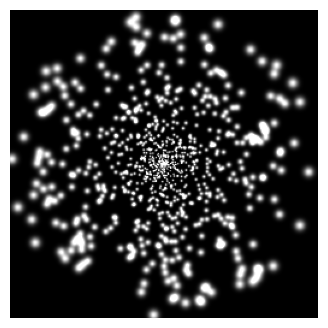

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [ ]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Loss = 0.0310:   0%|▋                                                                                                                                                                                                                                                     | 6/2000 [00:00<00:34, 57.75iter/s]

Loss = 0.0028: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 230.11iter/s]


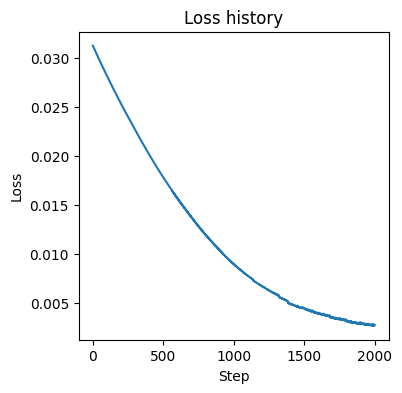

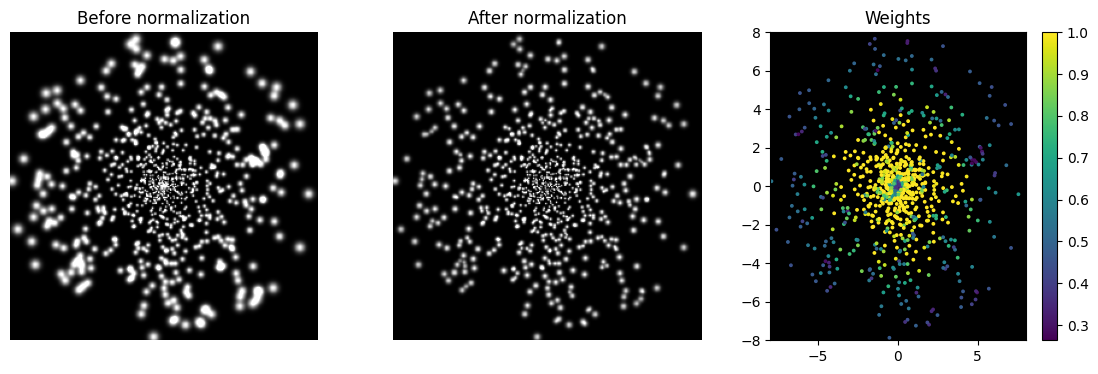

Percentage of amplitude: 76.87%


In [4]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [ ]:
from phosphene.density import VisualFieldMapper

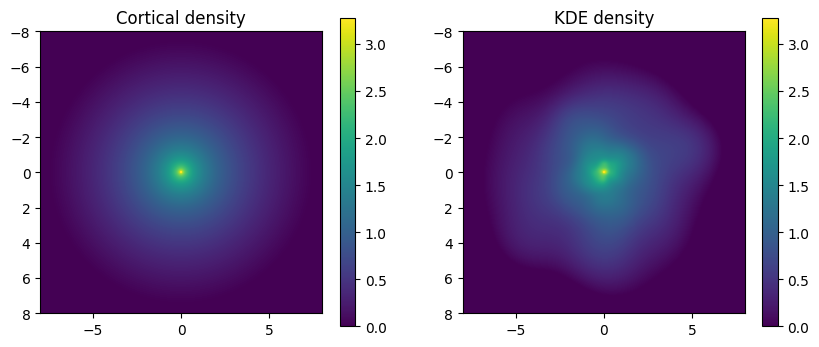

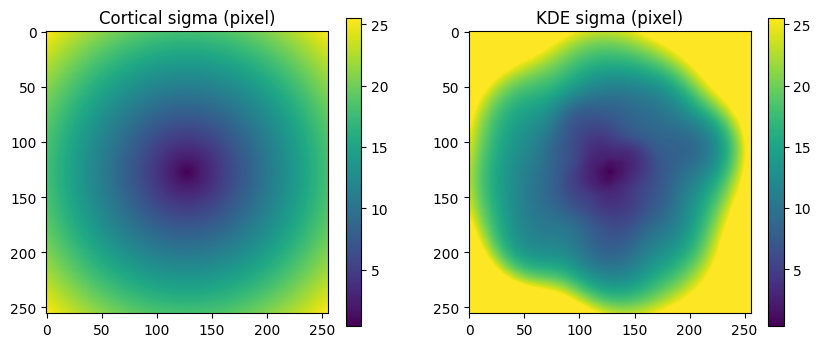

In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [7]:
from data.local_datasets import LaPaDataset
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation
import yaml

def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked


cfg = load_config('../config/256x256_LaPa.yaml')
LaPa_dataset = LaPaDataset(cfg)

In [8]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [9]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer_gauss = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer_gauss.eval()

UnifiedInputModulation()

In [ ]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

In [ ]:
image_processing_dict = {}

threshold = params['thresholding']['rheobase']

for image_index, batch in enumerate(LaPa_dataset):
    image = batch['image'].unsqueeze(0)
    contour = batch['contour'].unsqueeze(0)

    # dilate the contour 5x5
    contour = dilation5x5(contour)
    # contour = modified_cdf_normalization(contour, 1)

    LoG = layer(image).clip(0, None)
    LoG = (LoG - LoG.min()) / (LoG.max() - LoG.min())
    LoG = LoG.max(1, keepdim=True).values

    grayscale = image.mean(dim=1, keepdim=True)
    grayscale_gauss = layer_gauss(grayscale).clip(0, None)

    canny_edge = cv2.Canny((image*255).squeeze(0).permute(1,2,0).cpu().numpy().astype(np.uint8), 100, 200)
    canny_edge = torch.tensor(canny_edge).float().cuda().detach()
    canny_edge = canny_edge / canny_edge.max()
    canny_edge = canny_edge.unsqueeze(0).unsqueeze(0)

    random_image = rand_perlin_2d((256, 256), (4, 4)).unsqueeze(0).unsqueeze(0).cuda().detach()
    random_image = (random_image - random_image.min()) / (random_image.max() - random_image.min())

    # 1) Grayscale
    simulator.reset()
    grayscale_electrode = simulator.sample_stimulus(grayscale, rescale=True)
    grayscale_electrode = robust_percentile_normalization(grayscale_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_electrode = grayscale_electrode * stim_weights
    grayscale_phosphenes = simulator(grayscale_electrode).unsqueeze(0).unsqueeze(0)

    # 1.5) Gaussian
    simulator.reset()
    grayscale_gauss_electrode = simulator.sample_stimulus(grayscale_gauss, rescale=True)
    grayscale_gauss_electrode = robust_percentile_normalization(grayscale_gauss_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    grayscale_gauss_electrode = grayscale_gauss_electrode * stim_weights
    grayscale_gauss_phosphenes = simulator(grayscale_gauss_electrode).unsqueeze(0).unsqueeze(0)

    # 2) Contour
    simulator.reset()
    contour_electrode = simulator.sample_stimulus(contour, rescale=True)
    contour_electrode = robust_percentile_normalization(contour_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    contour_electrode = contour_electrode * stim_weights
    contour_phosphenes = simulator(contour_electrode).unsqueeze(0).unsqueeze(0)

    # 2.5) Canny edge
    simulator.reset()
    canny_edge_electrode = simulator.sample_stimulus(canny_edge, rescale=True)
    canny_edge_electrode = robust_percentile_normalization(canny_edge_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    canny_edge_electrode = canny_edge_electrode * stim_weights
    canny_edge_phosphenes = simulator(canny_edge_electrode).unsqueeze(0).unsqueeze(0)

    # 3) LoG response
    simulator.reset()
    LoG_electrode = simulator.sample_stimulus(LoG, rescale=True)
    LoG_electrode = robust_percentile_normalization(LoG_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    LoG_electrode = LoG_electrode * stim_weights
    LoG_phosphenes = simulator(LoG_electrode).unsqueeze(0).unsqueeze(0)

    # Sanity check: randomize the stimulation vector
    simulator.reset()
    random_electrode = simulator.sample_stimulus(random_image, rescale=True)
    random_electrode = robust_percentile_normalization(random_electrode, amplitude, threshold=threshold, low_perc=5, high_perc=90, gamma=2/3)
    random_electrode = random_electrode * stim_weights
    random_phosphenes = simulator(random_electrode).unsqueeze(0).unsqueeze(0)
    

    image_processing_dict[image_index] = {
    'image': image,
    'grayscale': {
        'stim': grayscale,
        'phosphenes': grayscale_phosphenes
    },
    'grayscale_gauss': {
        'stim': grayscale_gauss,
        'phosphenes': grayscale_gauss_phosphenes
    },
    'contour': {
        'stim': contour,
        'phosphenes': contour_phosphenes
    },
    'canny_edge': {
        'stim': canny_edge,
        'phosphenes': canny_edge_phosphenes
    },
    'LoG_response': {
        'stim': LoG,
        'phosphenes': LoG_phosphenes
    },
    'random': {
        'stim': random_image,
        'phosphenes': random_phosphenes
    } 
    }
    
    if image_index == 25:
        break

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
torch.use_deterministic_algorithms(False)

# Evaluate

In [69]:
import seaborn as sns

def plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title=None, invert_cmap=True):
    """
    Plot three heatmaps showing the loss matrices for:
      1. Stimulus vs. Stimulus (symmetric)
      2. Stimulus vs. Phosphene (non-symmetric)
      3. Phosphene vs. Phosphene (symmetric)
    """
  	# everything to cpu
    stim_stim_matrix = stim_stim_matrix.cpu().numpy()
    stim_phos_matrix = stim_phos_matrix.cpu().numpy()
    phos_phos_matrix = phos_phos_matrix.cpu().numpy()

    sns.set(font_scale=0.7)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
                xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[0].set_title("Stimulus vs Stimulus")
    axes[0].xaxis.tick_top()

    sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[1].set_title("Stimulus vs Phosphene")
    axes[1].xaxis.tick_top()

    sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[2].set_title("Phosphene vs Phosphene")
    axes[2].xaxis.tick_top()

    if title:
        plt.suptitle(title, size=16)

    plt.tight_layout()
    plt.show()

In [66]:
def evaluate_loss_matrices(image_processing_dict, loss_fn):
    """
    Evaluate the loss matrices for a given loss function.
    """
    n_images = len(image_processing_dict) # number of images
    n_stimuli = len(image_processing_dict[0].keys())-1 # number of stimuli

    # Initialize the loss matrices
    stim_stim_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    stim_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    phos_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()

    for image in range(n_images):
        for i, (key, stim_dict) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
            if key == 'image':
                continue
            stim = stim_dict['stim'].cuda()
            phos = stim_dict['phosphenes'].cuda()

            for j, (key2, stim_dict2) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
                if key2 == 'image':
                    continue
                stim2 = stim_dict2['stim'].cuda()
                phos2 = stim_dict2['phosphenes'].cuda()

                # Compute the loss matrices
                stim_stim_matrix[i, j] += loss_fn(stim, stim2)
                stim_phos_matrix[i, j] += loss_fn(stim, phos2)
                phos_phos_matrix[i, j] += loss_fn(phos, phos2)

    # Normalize the loss matrices by the number of images
    stim_stim_matrix /= n_images
    stim_phos_matrix /= n_images
    phos_phos_matrix /= n_images

    return stim_stim_matrix, stim_phos_matrix, phos_phos_matrix

In [67]:
# Labels for the conditions
labels_stim = ["Gray S", "Gauss S", "Cont S", "Canny S", "LoG S", "Random S"]
labels_phos = ["Gray P", "Gauss P", "Cont P", "Canny P", "LoG P", "Random P"]

### Feature Similarity Index Measure (FSIM) 

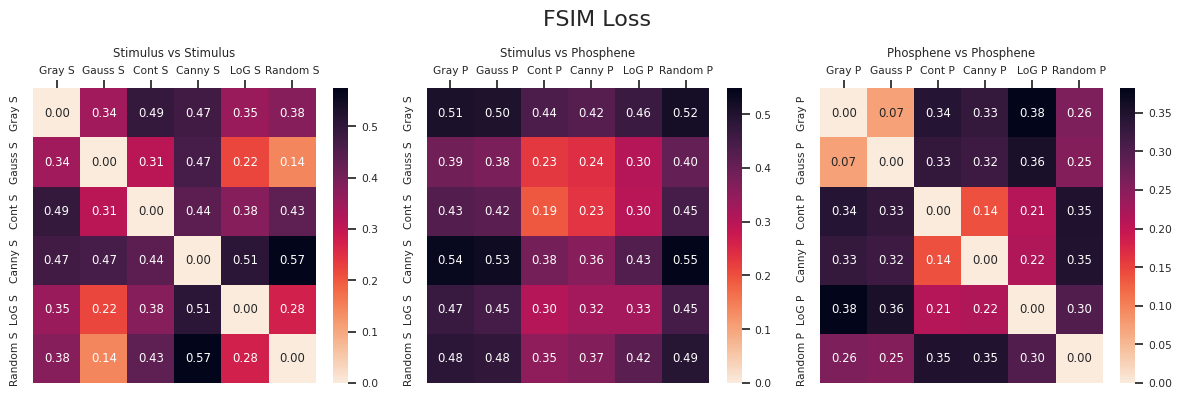

In [72]:
import piq
torch.use_deterministic_algorithms(False)

fsim_loss = piq.FSIMLoss(chromatic=False, min_length=7, scales=4).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, fsim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSIM Loss')

### Learned Perceptual Image Patch Similarity (LPIPS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


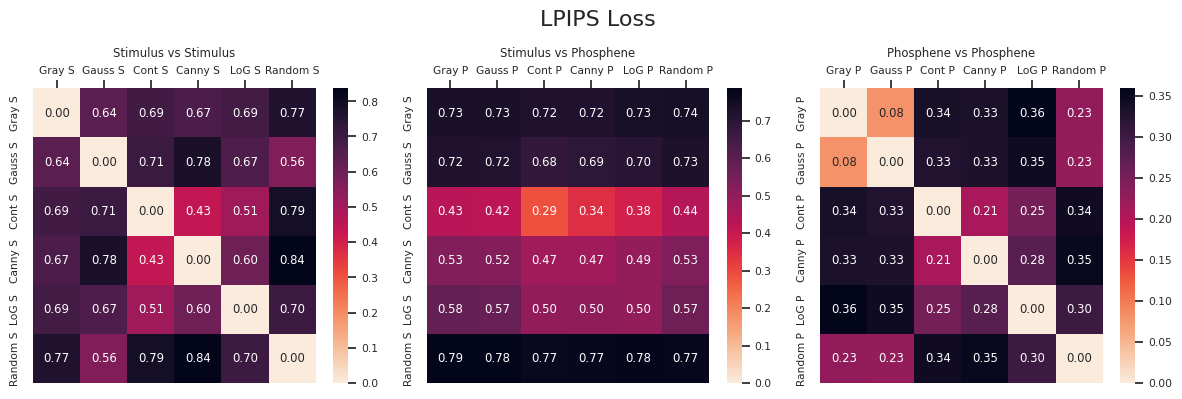

In [73]:
LPIPS_loss = piq.LPIPS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, LPIPS_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='LPIPS Loss')

### Perceptual Image-Error Assessment through Pairwise Preference (PieAPP)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'


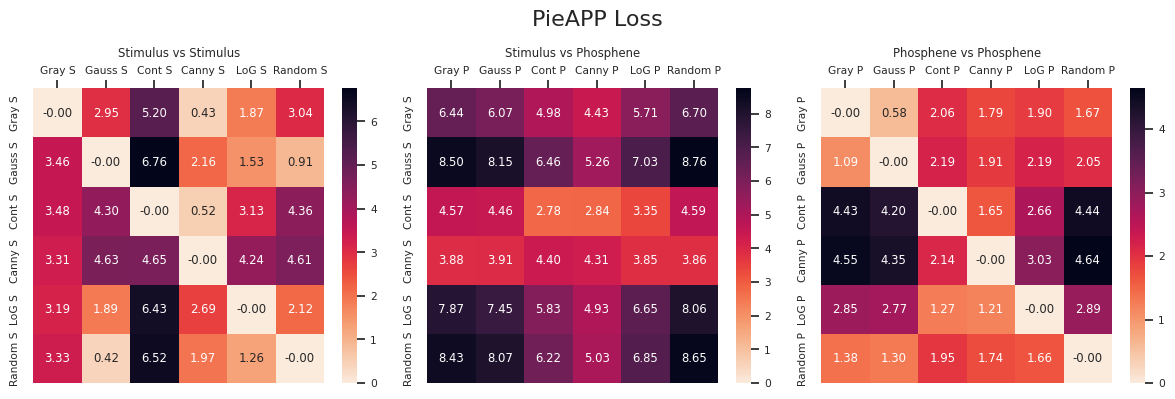

In [74]:
pieapp_loss = piq.PieAPP()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, pieapp_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='PieAPP Loss')

### Deep Image Structure and Texture Similarity (DISTS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


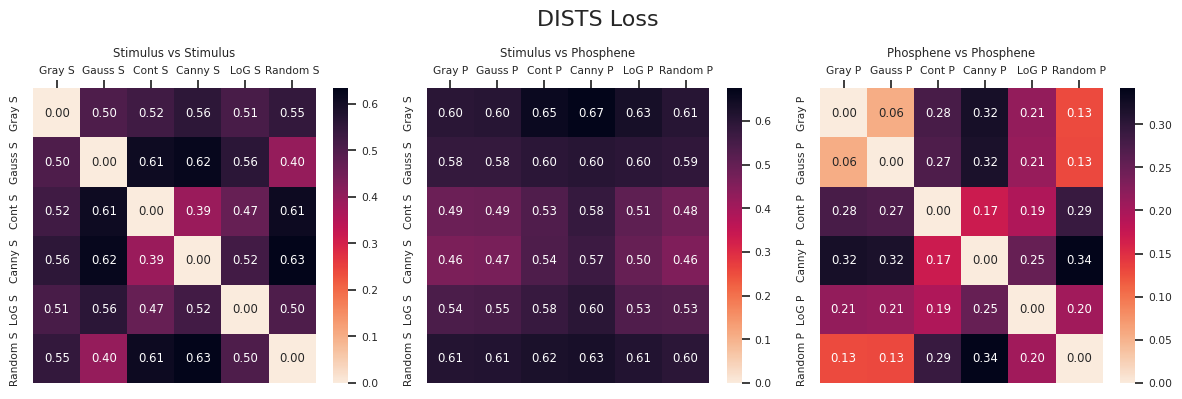

In [75]:
dists_loss = piq.DISTS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dists_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DISTS Loss')

### Content Loss

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


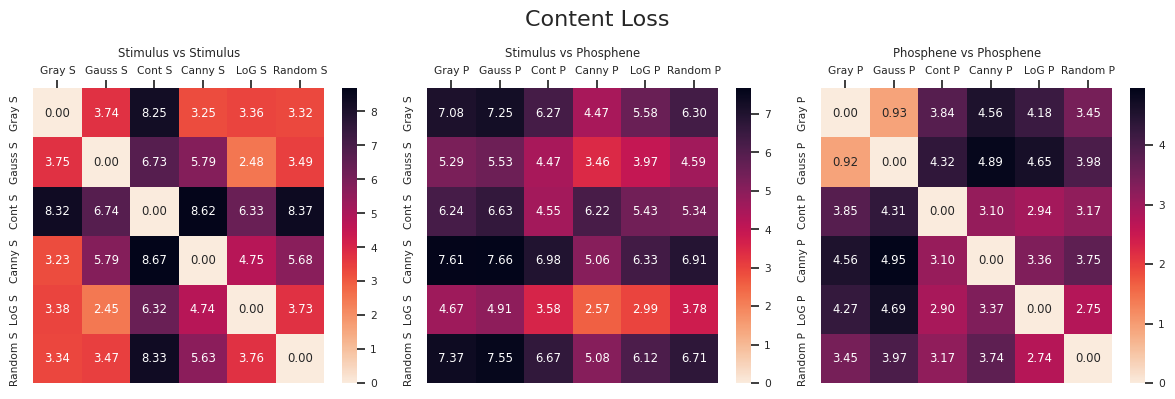

In [76]:
contentloss = piq.ContentLoss(feature_extractor='vgg19', normalize_features=False, layers = ['relu2_2'], distance="swd")

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, contentloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Content Loss')

### Strucural Similarity (SSIM)

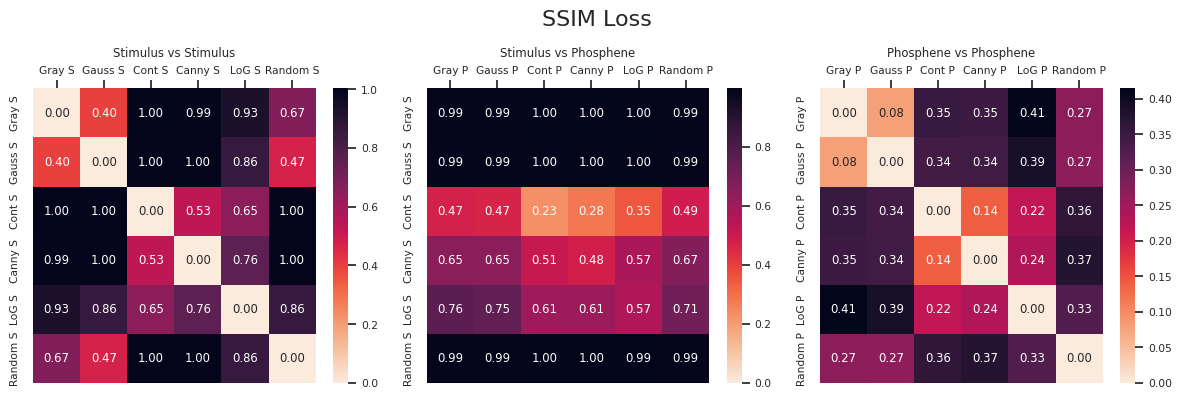

In [77]:
ssim_loss = piq.SSIMLoss()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, ssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SSIM Loss')

### Multi-Scale Structural Similarity (MS-SSIM)

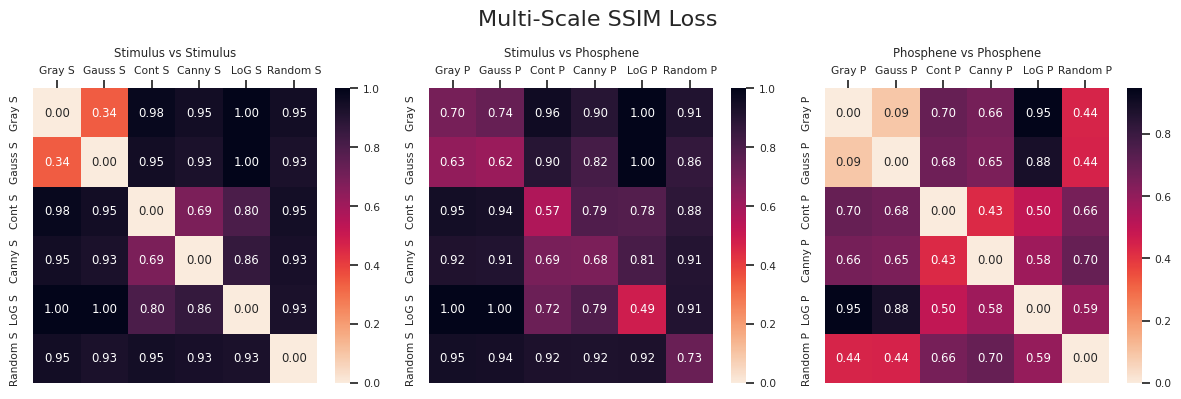

In [78]:
msssim_loss = piq.MultiScaleSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, msssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale SSIM Loss')

### Information Content Weighted Structural Similarity (IW-SSIM)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:256: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  lo_x = F.conv2d(input=lo_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, ::2, :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:272: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  hi_x = F.conv2d(input=hi_x, weight=kernel_t.unsqueeze(0), padding=0)[:, :, :x.size(-2), :]
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/iw_ssim.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descripto

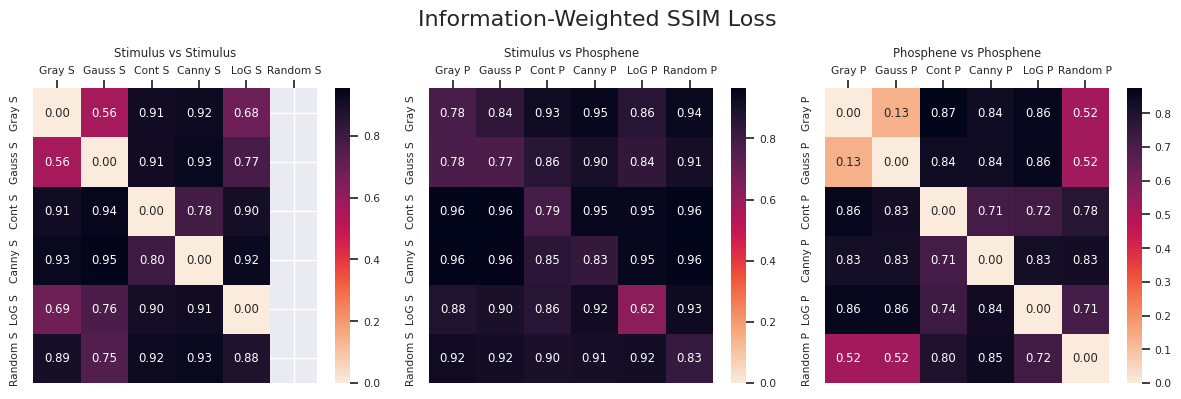

In [79]:
iwssim_loss = piq.InformationWeightedSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, iwssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Information-Weighted SSIM Loss')

### Visual Information Fidelity (VIFp)

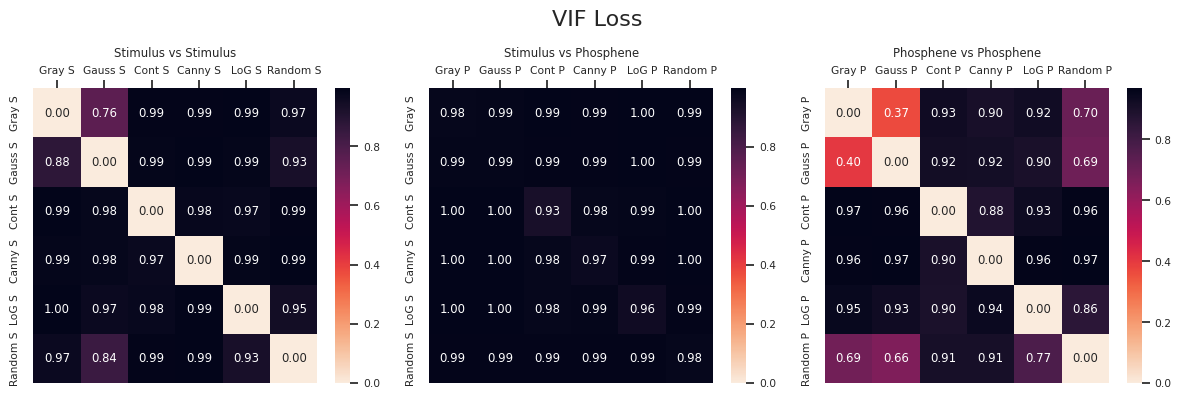

In [80]:
vifloss = piq.VIFLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vifloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VIF Loss')

### Spectral Residual based Similarity Measure (SR-SIM)

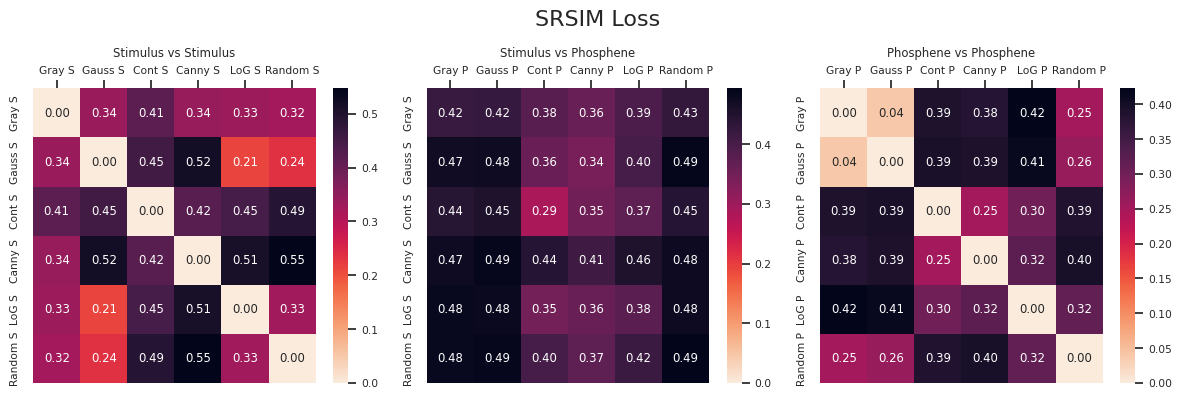

In [82]:
srsimloss = piq.SRSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, srsimloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SRSIM Loss')

### Gradient Magnitude Similarity Deviation (GMSD)

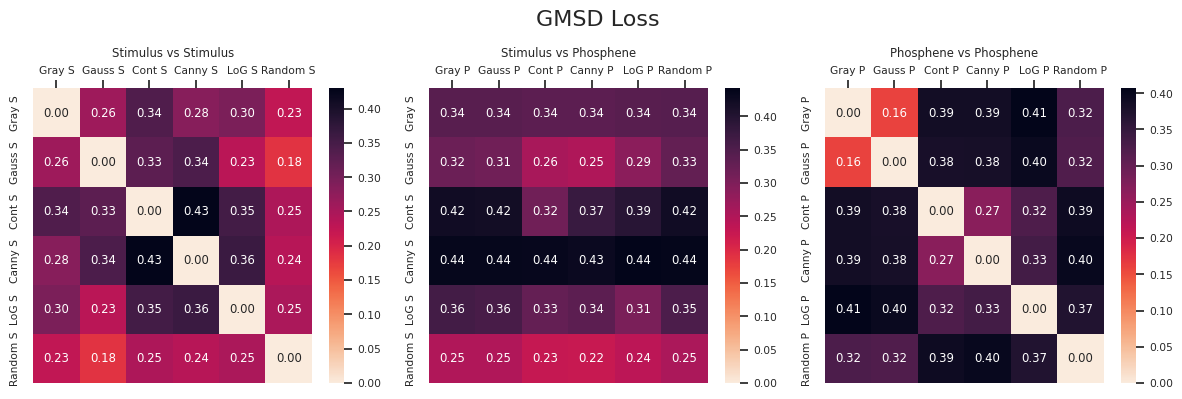

In [83]:
loss = piq.GMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='GMSD Loss')

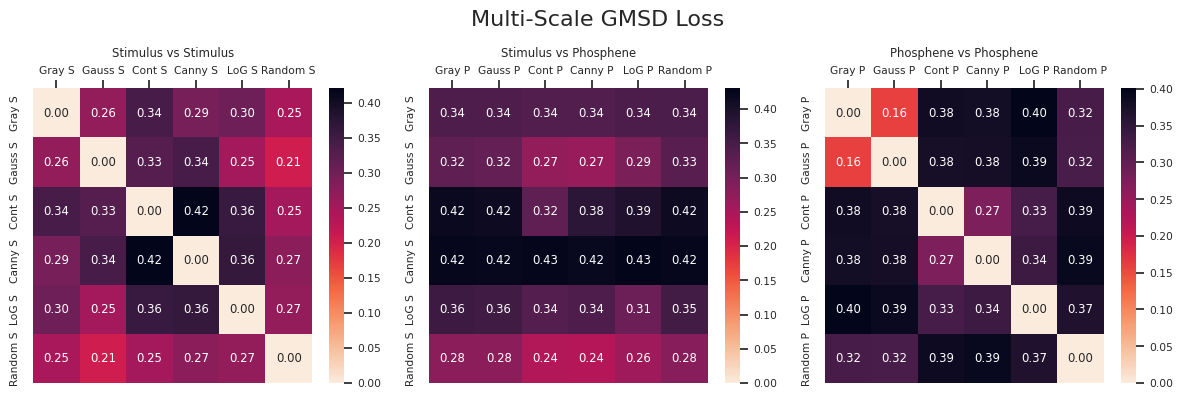

In [85]:
loss = piq.MultiScaleGMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale GMSD Loss')

### Visual Saliency-induced Index (VSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


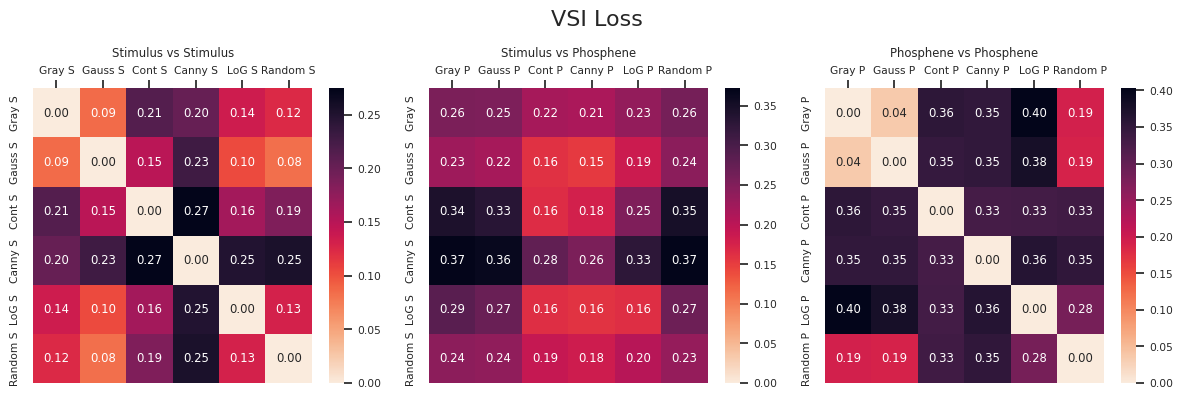

In [87]:
vsiloss = piq.VSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VSI Loss')

### DCT Subband Similarity Index (DSS)

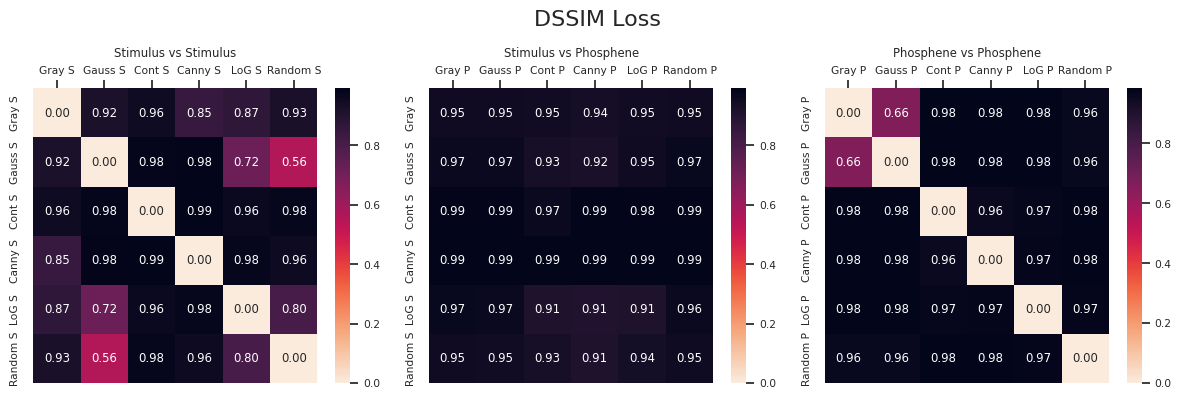

In [88]:
dssloss = piq.DSSLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dssloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DSSIM Loss')

### Haar Perceptual Similarity Index (HaarPSI)

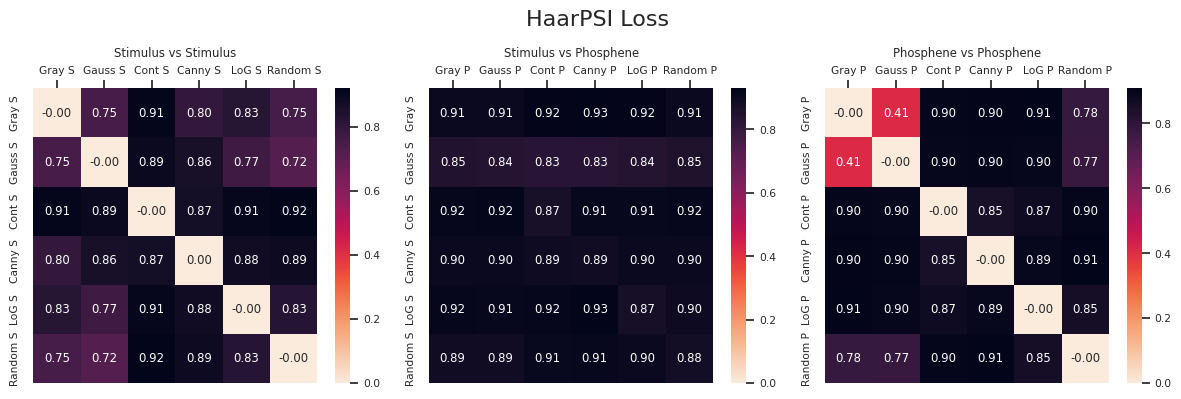

In [89]:
haarloss = piq.HaarPSILoss(scales=3).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, haarloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='HaarPSI Loss')

### Mean Deviation Similarity Index (MDSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


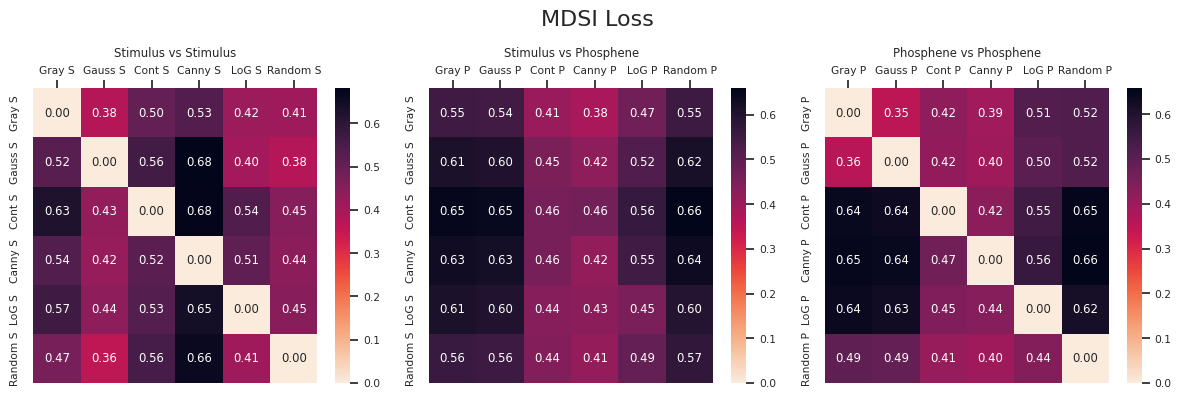

In [90]:
mdsiloss = piq.MDSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mdsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MDSI Loss')

# Mutual Information

In [94]:
# import F
import torch.nn.functional as F

def mutual_information(img1, img2, patch_size=256, bins=64, eps=1e-10, plot_hist=False):
    """
    Compute spatially aware mutual information for a batch of images.
    
    Args:
        img1, img2 (torch.Tensor): Input images of shape (B, C, H, W).
        patch_size (int): Size of the square patch.
        bins (int): Number of intensity bins.
        eps (float): Small constant to avoid division by zero.
        plot_hist (bool): If True, plot the joint histogram of the first patch of the first image.
        
    Returns:
        avg_mi (torch.Tensor): The average mutual information over patches and over the batch.
    """
    B, C, H, W = img1.shape
    # Assume H and W are divisible by patch_size.
    n_h = H // patch_size
    n_w = W // patch_size
    n_patches = n_h * n_w

    # Extract non-overlapping patches.
    # After unfolding, shape: (B, C, n_h, n_w, patch_size, patch_size)
    patches1 = img1.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches2 = img2.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)

    # Rearrange dimensions so that patches are the third dimension:
    # New shape: (B, n_h, n_w, C, patch_size, patch_size)
    patches1 = patches1.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches2 = patches2.permute(0, 2, 3, 1, 4, 5).contiguous()

    # Flatten each patch into a vector by combining the channel and spatial dimensions.
    # New shape: (B, n_patches, C * patch_size * patch_size)
    patches1 = patches1.view(B, n_patches, C * patch_size * patch_size)
    patches2 = patches2.view(B, n_patches, C * patch_size * patch_size)

    # Normalize each patch independently to [0, 1].
    min1, _ = patches1.min(dim=2, keepdim=True)
    max1, _ = patches1.max(dim=2, keepdim=True)
    patches1 = (patches1 - min1) / (max1 - min1 + eps)
    min2, _ = patches2.min(dim=2, keepdim=True)
    max2, _ = patches2.max(dim=2, keepdim=True)
    patches2 = (patches2 - min2) / (max2 - min2 + eps)

    # Quantize each patch into bins.
    bin_indices1 = torch.clamp((patches1 * (bins - 1)).long(), 0, bins - 1)  # shape: (B, n_patches, patch_area)
    bin_indices2 = torch.clamp((patches2 * (bins - 1)).long(), 0, bins - 1)

    # Compute joint indices for each pixel in each patch.
    joint_indices = bin_indices1 * bins + bin_indices2  # shape: (B, n_patches, patch_area)

    # One-hot encode the joint indices. The one-hot dimension is bins*bins.
    one_hot = F.one_hot(joint_indices, num_classes=bins*bins).float()  # shape: (B, n_patches, patch_area, bins*bins)
    
    # Sum over the patch area to get a joint histogram for each patch.
    hist = one_hot.sum(dim=2)  # shape: (B, n_patches, bins*bins)
    
    # Convert counts to probabilities (per patch).
    hist = hist / (hist.sum(dim=2, keepdim=True) + eps)  # shape: (B, n_patches, bins*bins)
    joint_prob = hist.view(B, n_patches, bins, bins)

    # Compute marginal probabilities for each patch.
    p1 = joint_prob.sum(dim=3, keepdim=True)  # shape: (B, n_patches, bins, 1)
    p2 = joint_prob.sum(dim=2, keepdim=True)  # shape: (B, n_patches, 1, bins)

    # Compute MI for each patch.
    mi_each = (joint_prob * torch.log((joint_prob + eps) / (p1 * p2 + eps))).sum(dim=(2,3))  # shape: (B, n_patches)

    # Average MI per image, then average over the batch.
    mi_per_image = mi_each.mean(dim=1)  # shape: (B,)
    avg_mi = mi_per_image.mean()

    if plot_hist:
        # Plot the joint histogram for the first patch of the first image.
        plt.figure(figsize=(6,5))
        plt.imshow(joint_prob[0, 0].cpu(), cmap='hot', interpolation='nearest')
        plt.title('Joint Histogram for First Patch of First Image')
        plt.xlabel('Image 1 Intensity Bins')
        plt.ylabel('Image 2 Intensity Bins')
        plt.colorbar()
        plt.grid(False)
        plt.show()

    return avg_mi

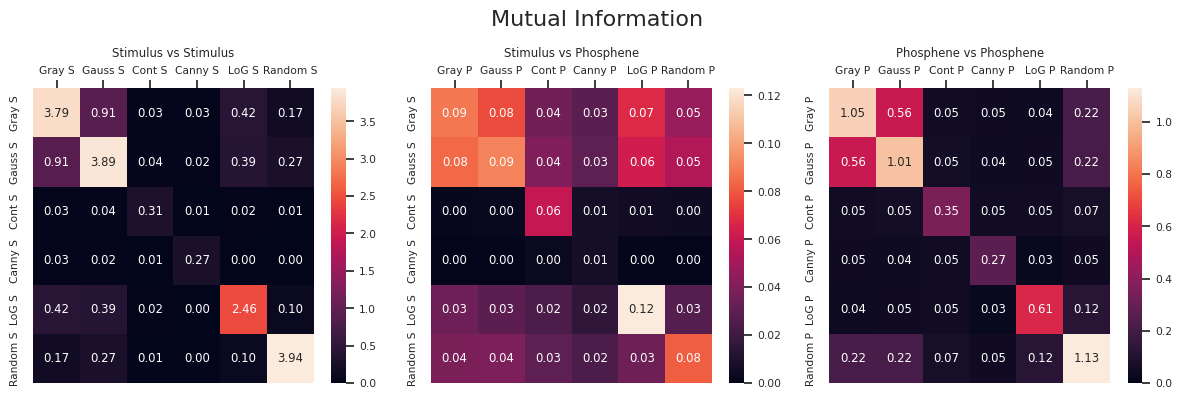

In [95]:
mi_loss = mutual_information

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mi_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Mutual Information', invert_cmap=False)

# Fourier

In [100]:
def plot_frequency_histogram(image, bins=100, title=None):
    """
    Compute and plot histogram of the frequency spectrum of an image.
    """
    # Compute the 2D FFT of the image
    freq = np.fft.fft2(image)
    freq_shifted = np.fft.fftshift(freq)
    
    # Compute magnitude spectrum and flatten it
    magnitude_spectrum = np.abs(freq_shifted).flatten()
    
    # Normalize magnitude spectrum
    magnitude_spectrum = magnitude_spectrum / magnitude_spectrum.max()

    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(magnitude_spectrum, bins=bins, color='steelblue', alpha=0.8)
    plt.title(f'Frequency Spectrum Histogram\n{title}' if title else 'Frequency Spectrum Histogram')
    plt.xlabel('Normalized Magnitude')
    plt.ylabel('Frequency Count')
    # log scale
    plt.yscale('log')
    plt.grid(alpha=0.3)
    plt.show()

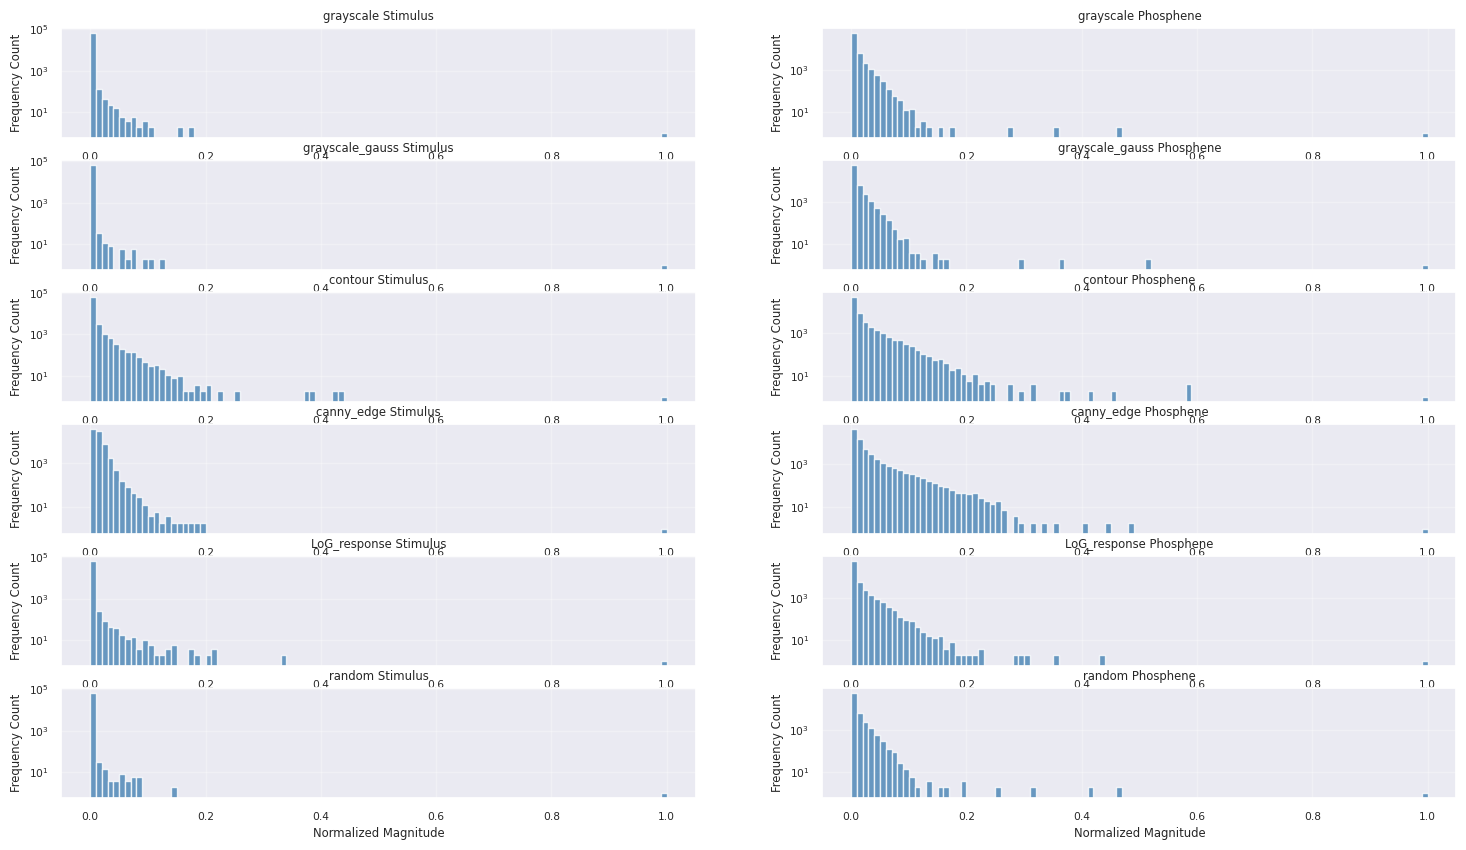

In [116]:
# plot histograms side by side 2 * 6 in subplots
image_index = 5

fig, axes = plt.subplots(6, 2, figsize=(18, 10))
for i, (key, stim_dict) in enumerate([stimuli for stimuli in image_processing_dict[image_index].items() if stimuli[0] != 'image']):
    if key == 'image':
        continue
    stim = stim_dict['stim'].cpu().squeeze(0).squeeze(0).numpy()
    phos = stim_dict['phosphenes'].cpu().squeeze(0).squeeze(0).numpy()

    freq_stim = np.fft.fft2(stim)
    freq_shifted_stim = np.fft.fftshift(freq_stim)
    magnitude_spectrum_stim = np.abs(freq_shifted_stim).flatten()
    magnitude_spectrum_stim = magnitude_spectrum_stim / magnitude_spectrum_stim.max()

    freq_phos = np.fft.fft2(phos)
    freq_shifted_phos = np.fft.fftshift(freq_phos)
    magnitude_spectrum_phos = np.abs(freq_shifted_phos).flatten()
    magnitude_spectrum_phos = magnitude_spectrum_phos / magnitude_spectrum_phos.max()

    axes[i, 0].hist(magnitude_spectrum_stim.flatten(), bins=100, color='steelblue', alpha=0.8)
    axes[i, 0].set_title(f'{key} Stimulus')
    axes[i, 0].set_xlabel('Normalized Magnitude')
    axes[i, 0].set_ylabel('Frequency Count')
    axes[i, 0].grid(alpha=0.3)
    axes[i, 1].hist(magnitude_spectrum_phos.flatten(), bins=100, color='steelblue', alpha=0.8)
    axes[i, 1].set_title(f'{key} Phosphene')
    axes[i, 1].set_xlabel('Normalized Magnitude')
    axes[i, 1].set_ylabel('Frequency Count')
    axes[i, 1].grid(alpha=0.3)
    # log scale
    axes[i, 0].set_yscale('log')
    axes[i, 1].set_yscale('log')

plt.show()